In [1]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/BayArea_GIS')

medium_duty_class = [3, 4, 5, 6] # ref: https://afdc.energy.gov/data/10380
heavy_duty_class = [7, 8]

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}

In [2]:
registration_data = read_csv('registration/TEXAS_MDHDbybiz.csv')
registration_data.loc[:, 'MDV'] = registration_data.loc[:, 'totcount'] * (registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
0 * (registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
registration_data.loc[:, 'HDV'] = 0 * (registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
registration_data.loc[:, 'totcount'] * (registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
print(registration_data.totcount.sum())
registration_data.head(5)

623668


,Unnamed: 0,zip_code,vocation,carrier_type,business_name,fuel,vin_gvw,vehicle_type,yr_mdl,totcount,MDV,HDV
0,1,73301,INDIVIDUAL,INDIVIDUAL,31556.0,DIESEL,8,TRACTOR TRUCK,1994,1,0,1
1,2,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,4,PICKUP,2008,1,1,0
2,3,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,6,STRAIGHT TRUCK,2005,1,1,0
3,4,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,STRAIGHT TRUCK,1990,1,0,1
4,5,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,TRACTOR TRUCK,1989,1,0,1


In [3]:
# classify body type and fuel type
# print(registration_data.vehicle_type.unique())
print(registration_data.fuel.unique())
registration_data.loc[:, 'vehicle_class'] = 'HDV'
registration_data.loc[registration_data['vin_gvw'].isin(medium_duty_class), 'vehicle_class'] = 'MDV'
truck_type_lookup = {'STRAIGHT TRUCK': 'Vocational',
                    'TRACTOR TRUCK': 'Tractor',
                    'CAB CHASSIS': 'Vocational',
                    'CUTAWAY': 'Vocational',
                    'INCOMPLETE (STRIP CHASSIS)': 'Vocational',
                    'STEP VAN': 'Vocational',
                    'VAN CARGO': 'Vocational',
                    'GLIDERS': 'Tractor',
                     'PICKUP': 'Vocational'}
# assign and filter body type
registration_data.loc[:, 'body type'] = registration_data.loc[:, 'vehicle_type'].map(truck_type_lookup)
registration_data = registration_data.dropna(subset = ['body type'])

hdv_fuels = ['DIESEL']
mdv_fuels = ['DIESEL', 'GAS']
fuel_filter_hdt = (registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class) ) & \
(registration_data.loc[:, 'fuel'].isin(hdv_fuels))
fuel_filter_mdt = (registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class) ) & \
(registration_data.loc[:, 'fuel'].isin(mdv_fuels))

registration_data = registration_data.loc[fuel_filter_hdt | fuel_filter_mdt]
print(len(registration_data))

#create join vehicle type
registration_data.loc[:, 'vehicle type'] = registration_data.loc[:, 'fuel'] + ' ' + \
registration_data.loc[:, 'body type'] + ' ' + registration_data.loc[:, 'vehicle_class']
# filter by fuel
registration_data.head(5)

['DIESEL' 'GAS' 'UNKNOWN' 'FLEXIBLE' 'CONVERTIBLE' 'PROPANE'
 'COMPRESSED NATURAL GAS']
309095


,Unnamed: 0,zip_code,vocation,carrier_type,business_name,fuel,vin_gvw,vehicle_type,yr_mdl,totcount,MDV,HDV,vehicle_class,body type,vehicle type
0,1,73301,INDIVIDUAL,INDIVIDUAL,31556.0,DIESEL,8,TRACTOR TRUCK,1994,1,0,1,HDV,Tractor,DIESEL Tractor HDV
1,2,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,4,PICKUP,2008,1,1,0,MDV,Vocational,DIESEL Vocational MDV
2,3,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,6,STRAIGHT TRUCK,2005,1,1,0,MDV,Vocational,DIESEL Vocational MDV
3,4,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,STRAIGHT TRUCK,1990,1,0,1,HDV,Vocational,DIESEL Vocational HDV
4,5,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,TRACTOR TRUCK,1989,1,0,1,HDV,Tractor,DIESEL Tractor HDV


total private carriers  45081
total private trucks  216050.0
max private trucks in a firm 3330.0
avg. private trucks in a firm 4.792484638761341
vehicle type
DIESEL Vocational HDV    54151.0
DIESEL Tractor HDV       89731.0
DIESEL Vocational MDV    59988.0
GAS Vocational MDV       12180.0
dtype: float64


Text(0.5, 1.0, 'private truck count distribution')

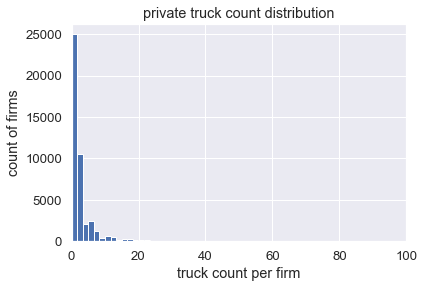

In [4]:
# private truck analysis
list_of_vehicle_type = ['DIESEL Vocational HDV', 'DIESEL Tractor HDV',
                        'DIESEL Vocational MDV', 'GAS Vocational MDV'] # select type of trucks
private_carriers = registration_data.loc[registration_data['carrier_type'] == 'PRIVATE']
private_truck_by_firm = pd.pivot_table(private_carriers, index = 'business_name', 
                                       columns = 'vehicle type',
                                       values = 'totcount', aggfunc = np.sum)
private_truck_by_firm = private_truck_by_firm.reset_index()
private_truck_by_firm = private_truck_by_firm.fillna(0)
private_truck_by_firm.loc[:, 'totcount'] = private_truck_by_firm.loc[:, list_of_vehicle_type].sum(axis = 1)
private_truck_by_firm.head(5)
print('total private carriers ', len(private_truck_by_firm))
print('total private trucks ', private_truck_by_firm['totcount'].sum())
print('max private trucks in a firm', private_truck_by_firm['totcount'].max())
print('avg. private trucks in a firm', private_truck_by_firm['totcount'].mean())
print(private_truck_by_firm[list_of_vehicle_type].sum())
private_truck_by_firm['totcount'].hist(bins = 2000)
plt.xlim([0, 100])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('private truck count distribution')

In [5]:
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']  
def fleet_composition_processor(data):
    size_interval = [-1, 2, 5, 10, 50, 100, 1000, data['totcount'].max()]
    data.loc[:, 'size_group'] = pd.cut(data['totcount'], 
                                       bins = size_interval, right = True, 
                                       labels = interval_name)
    # private_truck_by_firm.head(5)
    fleet_by_size = data.groupby('size_group').agg({'business_name': 'count',
                                                    'totcount': ['sum','std'],
                                                    'DIESEL Vocational HDV': 'sum',
                                                    'DIESEL Tractor HDV': 'sum',
                                                    'DIESEL Vocational MDV': 'sum',
                                                    'GAS Vocational MDV': 'sum'})
    fleet_by_size = fleet_by_size.reset_index()
    fleet_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                            'DIESEL Vocational HDV', 'DIESEL Tractor HDV', 
                            'DIESEL Vocational MDV', 'GAS Vocational MDV']
    # print(truck_count_by_size.head(5))

    fleet_by_size.loc[:, 'min_size'] = fleet_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
    fleet_by_size.loc[:, 'avg_truck_per_carrier'] = fleet_by_size.loc[:, 'total_trucks'] / fleet_by_size.loc[:, 'total_carriers']
    # truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
    # truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
    fleet_by_size.loc[:, 'fraction_of_carrier'] = fleet_by_size.loc[:, 'total_carriers'] / fleet_by_size.loc[:, 'total_carriers'].sum()
    fleet_by_size.loc[:, 'DIESEL Vocational HDV'] = fleet_by_size.loc[:, 'DIESEL Vocational HDV'] / fleet_by_size.loc[:, 'total_trucks']
    fleet_by_size.loc[:, 'DIESEL Tractor HDV'] = fleet_by_size.loc[:, 'DIESEL Tractor HDV'] / fleet_by_size.loc[:, 'total_trucks']
    fleet_by_size.loc[:, 'DIESEL Vocational MDV'] = fleet_by_size.loc[:, 'DIESEL Vocational MDV'] / fleet_by_size.loc[:, 'total_trucks']
    fleet_by_size.loc[:, 'GAS Vocational MDV'] = fleet_by_size.loc[:, 'GAS Vocational MDV'] / fleet_by_size.loc[:, 'total_trucks']
    return(fleet_by_size)

In [6]:
private_truck_count_by_size = fleet_composition_processor(private_truck_by_firm)
private_truck_count_by_size.to_csv('registration/TX_private_fleet_size_distribution_V2.csv', index = False, sep = ',')
private_truck_count_by_size.head(7)

,fleet_size,total_carriers,total_trucks,total_truck_std,DIESEL Vocational HDV,DIESEL Tractor HDV,DIESEL Vocational MDV,GAS Vocational MDV,min_size,avg_truck_per_carrier,fraction_of_carrier
0,0-2,31996,38985.0,0.413643,0.172759,0.284263,0.441631,0.101347,1,1.218434,0.709745
1,3-5,6960,25700.0,0.778908,0.224514,0.360078,0.361089,0.054319,3,3.692529,0.154389
2,6-10,3120,23327.0,1.370730,0.248853,0.392807,0.316072,0.042269,6,7.476603,0.069209
3,11-50,2589,52662.0,9.548775,0.277221,0.426038,0.262200,0.034541,11,20.340672,0.057430
4,51-100,232,16133.0,13.454372,0.301804,0.501333,0.172504,0.024360,51,69.538793,0.005146
5,101-1000,177,44584.0,175.758579,0.329872,0.504710,0.125202,0.040216,101,251.887006,0.003926
6,>1000,7,14659.0,621.722722,0.113650,0.491575,0.269118,0.125657,1001,2094.142857,0.000155


total for-hire carriers  10094
total for-hire trucks  52826.0
max for-hire trucks in a firm 1400.0
avg. for-hire trucks in a firm 5.233405983752724


vehicle type,business_name,DIESEL Tractor HDV,DIESEL Tractor MDV,DIESEL Vocational HDV,DIESEL Vocational MDV,GAS Vocational MDV,totcount
0,2.0,3.0,0.0,0.0,0.0,0.0,3.0
1,4.0,1.0,0.0,0.0,0.0,0.0,1.0
2,12.0,0.0,0.0,0.0,2.0,0.0,2.0
3,15.0,1.0,0.0,0.0,0.0,0.0,1.0
4,17.0,1.0,0.0,0.0,1.0,0.0,2.0


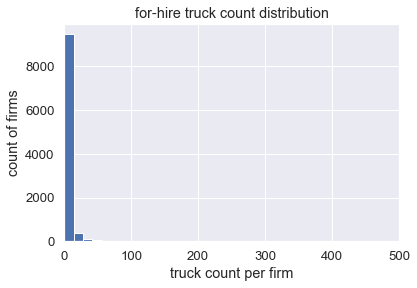

In [7]:
for_hire_carriers = registration_data.loc[registration_data['carrier_type'] == 'FOR HIRE']


for_hire_truck_by_firm = pd.pivot_table(for_hire_carriers, index = 'business_name', 
                                       columns = 'vehicle type',
                                       values = 'totcount', aggfunc = np.sum)
for_hire_truck_by_firm = for_hire_truck_by_firm.reset_index()
for_hire_truck_by_firm = for_hire_truck_by_firm.fillna(0)
for_hire_truck_by_firm.loc[:, 'totcount'] = for_hire_truck_by_firm.loc[:, list_of_vehicle_type].sum(axis = 1)


print('total for-hire carriers ', len(for_hire_truck_by_firm))
print('total for-hire trucks ', for_hire_truck_by_firm['totcount'].sum())
print('max for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].max())
print('avg. for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].mean())

for_hire_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-hire truck count distribution')

for_hire_truck_by_firm.head(5)

In [8]:
# for-hire truck analysis
for_hire_truck_count_by_size = fleet_composition_processor(for_hire_truck_by_firm)
for_hire_truck_count_by_size.to_csv('registration/TX_for_hire_fleet_size_distribution_V2.csv', index = False, sep = ',')
for_hire_truck_count_by_size.head(7)

,fleet_size,total_carriers,total_trucks,total_truck_std,DIESEL Vocational HDV,DIESEL Tractor HDV,DIESEL Vocational MDV,GAS Vocational MDV,min_size,avg_truck_per_carrier,fraction_of_carrier
0,0-2,6829,8425.0,0.423566,0.056261,0.778042,0.146588,0.019110,1,1.233709,0.676541
1,3-5,1677,6219.0,0.781045,0.063193,0.787265,0.129924,0.019617,3,3.708408,0.166138
2,6-10,780,5821.0,1.361454,0.081086,0.775640,0.132795,0.010479,6,7.462821,0.077274
3,11-50,686,14090.0,9.100769,0.089567,0.801561,0.092477,0.016395,11,20.539359,0.067961
4,51-100,69,4750.0,14.636400,0.103579,0.820632,0.053053,0.022737,51,68.840580,0.006836
5,101-1000,51,10922.0,170.766785,0.114265,0.736678,0.130562,0.018495,101,214.156863,0.005053
6,>1000,2,2599.0,142.128463,0.070412,0.912659,0.016545,0.000385,1001,1299.500000,0.000198


total for-lease carriers  2555
total for-lease trucks  60616.0
max for-lease trucks in a firm 7033.0
avg. for-lease trucks in a firm 23.72446183953033


vehicle type,business_name,DIESEL Tractor HDV,DIESEL Tractor MDV,DIESEL Vocational HDV,DIESEL Vocational MDV,GAS Vocational MDV,totcount
0,13.0,0.0,0.0,0.0,1.0,0.0,1.0
1,42.0,1.0,0.0,0.0,0.0,0.0,1.0
2,83.0,1.0,0.0,0.0,0.0,0.0,1.0
3,87.0,0.0,0.0,0.0,1.0,0.0,1.0
4,109.0,0.0,0.0,1.0,0.0,0.0,1.0


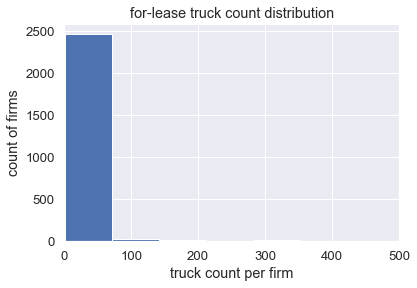

In [9]:
# for-leasing truck analysis
for_lease_carriers = registration_data.loc[registration_data['carrier_type'].isin(['FINANCE LEASE', \
                                                                                        'FULL SERVICE LEASE', \
                                                                                        'MANUFACTURER SPONSORED LEASE'])]


for_lease_truck_by_firm = pd.pivot_table(for_lease_carriers, index = 'business_name', 
                                       columns = 'vehicle type',
                                       values = 'totcount', aggfunc = np.sum)
for_lease_truck_by_firm = for_lease_truck_by_firm.reset_index()
for_lease_truck_by_firm = for_lease_truck_by_firm.fillna(0)
for_lease_truck_by_firm.loc[:, 'totcount'] = for_lease_truck_by_firm.loc[:, list_of_vehicle_type].sum(axis = 1)

print('total for-lease carriers ', len(for_lease_truck_by_firm))
print('total for-lease trucks ', for_lease_truck_by_firm['totcount'].sum())
print('max for-lease trucks in a firm', for_lease_truck_by_firm['totcount'].max())
print('avg. for-lease trucks in a firm', for_lease_truck_by_firm['totcount'].mean())

for_lease_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-lease truck count distribution')

for_lease_truck_by_firm.head(5)

In [10]:
for_lease_truck_count_by_size = fleet_composition_processor(for_lease_truck_by_firm)
for_lease_truck_count_by_size.to_csv('registration/TX_for_lease_fleet_size_distribution_V2.csv', index = False, sep = ',')
for_lease_truck_count_by_size.head(7)

,fleet_size,total_carriers,total_trucks,total_truck_std,DIESEL Vocational HDV,DIESEL Tractor HDV,DIESEL Vocational MDV,GAS Vocational MDV,min_size,avg_truck_per_carrier,fraction_of_carrier
0,0-2,1593,1955.0,0.419183,0.154987,0.379028,0.366240,0.099744,1,1.227244,0.623483
1,3-5,358,1337.0,0.798792,0.177263,0.482423,0.281227,0.059088,3,3.734637,0.140117
2,6-10,214,1612.0,1.382776,0.207196,0.494417,0.257444,0.040943,6,7.532710,0.083757
3,11-50,271,5889.0,10.098283,0.173714,0.592970,0.190525,0.042792,11,21.730627,0.106067
4,51-100,49,3374.0,14.610213,0.184351,0.590397,0.204801,0.020451,51,68.857143,0.019178
5,101-1000,60,18730.0,206.449581,0.183129,0.522744,0.264923,0.029204,101,312.166667,0.023483
6,>1000,10,27719.0,2212.891896,0.120711,0.638082,0.232296,0.008911,1001,2771.900000,0.003914
